# UCI regression 

In [1]:
import jax
import numpy as np
import pandas as pd
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

import datagen

from functools import partial
from rebayes_mini.methods import replay_sgd
from rebayes_mini.methods import gauss_filter as gfilter
from rebayes_mini.methods import robust_filter as rfilter
from rebayes_mini.methods import generalised_bayes_filter as gbfilter

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
uci = datagen.UCIDatasets("./data")
data = uci.sample_one_sided_noisy_dataset("kin8nm", p_error=0.01, seed=314, v_error=100.0)

X = jnp.array(data["X"])
y = jnp.array(data["y"])
ix_clean = ~data["err_where"].astype(bool)

In [5]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

In [6]:
key = jax.random.PRNGKey(314)
model = MLP()
params_init = model.init(key, X[:1])

## WLF-IMQ

In [7]:
lr = 1e-3

def callback_fn(bel, bel_pred, y, x, applyfn):
    yhat = applyfn(bel_pred.mean, x[None])
    return yhat

In [8]:
agent = gbfilter.IMQFilter(
    model.apply,
    dynamics_covariance=0.0,
    observation_covariance=1.0,
    soft_threshold=3.0
)

In [9]:
bel_init = agent.init_bel(params_init, cov=lr)

In [10]:
callback = partial(callback_fn, applyfn=agent.link_fn)
state_final, yhat = agent.scan(bel_init, y, X, callback)
yhat = yhat.squeeze()

In [11]:
errs = (y - yhat)[ix_clean]
jnp.sqrt(jnp.power(errs, 2).mean())

Array(0.8909317, dtype=float32)

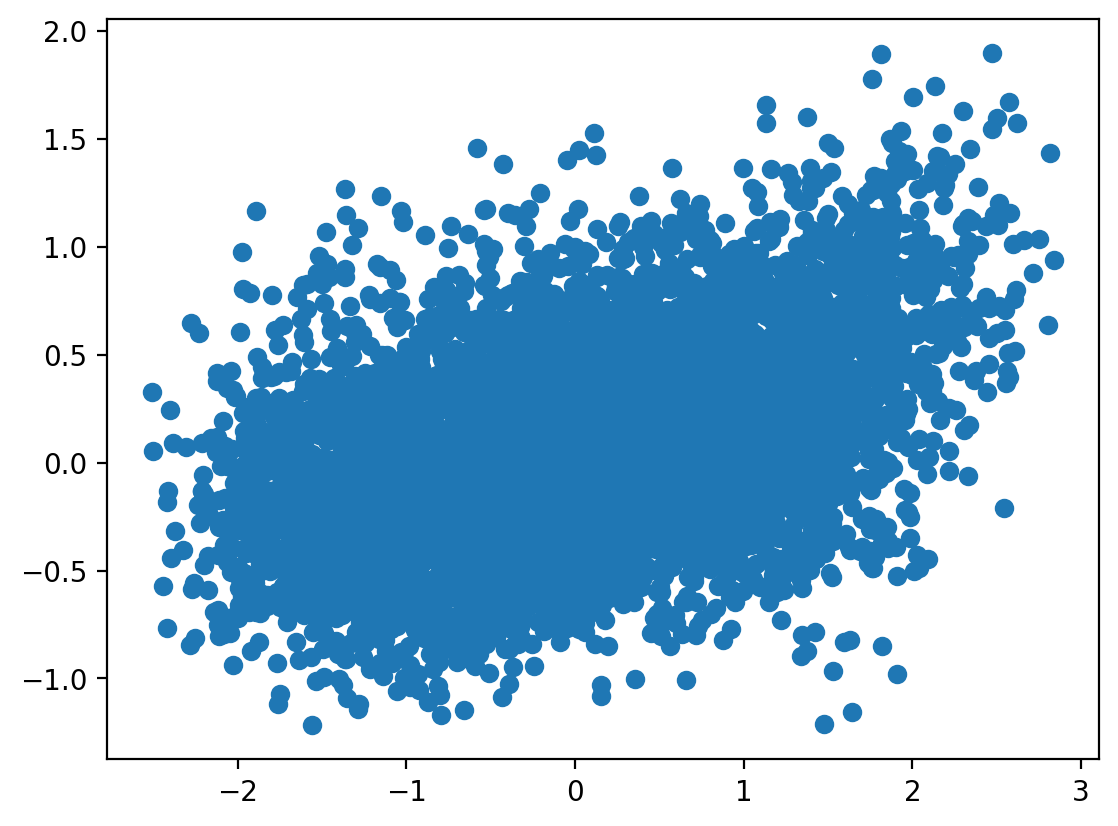

In [12]:
plt.scatter(y[ix_clean], yhat[ix_clean])

## EKF

In [13]:
agent = gfilter.ExtendedKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=0.0,
    observation_covariance=1.0 * jnp.eye(1),
)

bel_init = agent.init_bel(params_init, cov=lr)

callback = partial(callback_fn, applyfn=agent.vobs_fn)
state_final, yhat = agent.scan(bel_init, y, X, callback)
yhat = yhat.squeeze()

errs = (y - yhat)[ix_clean]
jnp.sqrt(jnp.power(errs, 2).mean())

Array(1.3034163, dtype=float32)

## IW-based EKF
(Agamenoni 2012)

In [14]:
agent = rfilter.ExtendedRobustKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=0.0,
    prior_observation_covariance=1.0 * jnp.eye(1),
    n_inner=1,
    noise_scaling=0.05,
)

In [15]:
bel_init = agent.init_bel(params_init, cov=lr)

In [16]:
def callback_fn(bel, bel_pred, y, x, applyfn):
    yhat = applyfn(bel_pred.mean, x[None])
    return yhat

In [17]:
callback = partial(callback_fn, applyfn=agent.vobs_fn)
state_final, yhat = agent.scan(bel_init, y, X, callback)
yhat = yhat.squeeze()

In [18]:
errs = (y - yhat)[ix_clean]
jnp.sqrt(jnp.power(errs, 2).mean())

Array(0.9665789, dtype=float32)

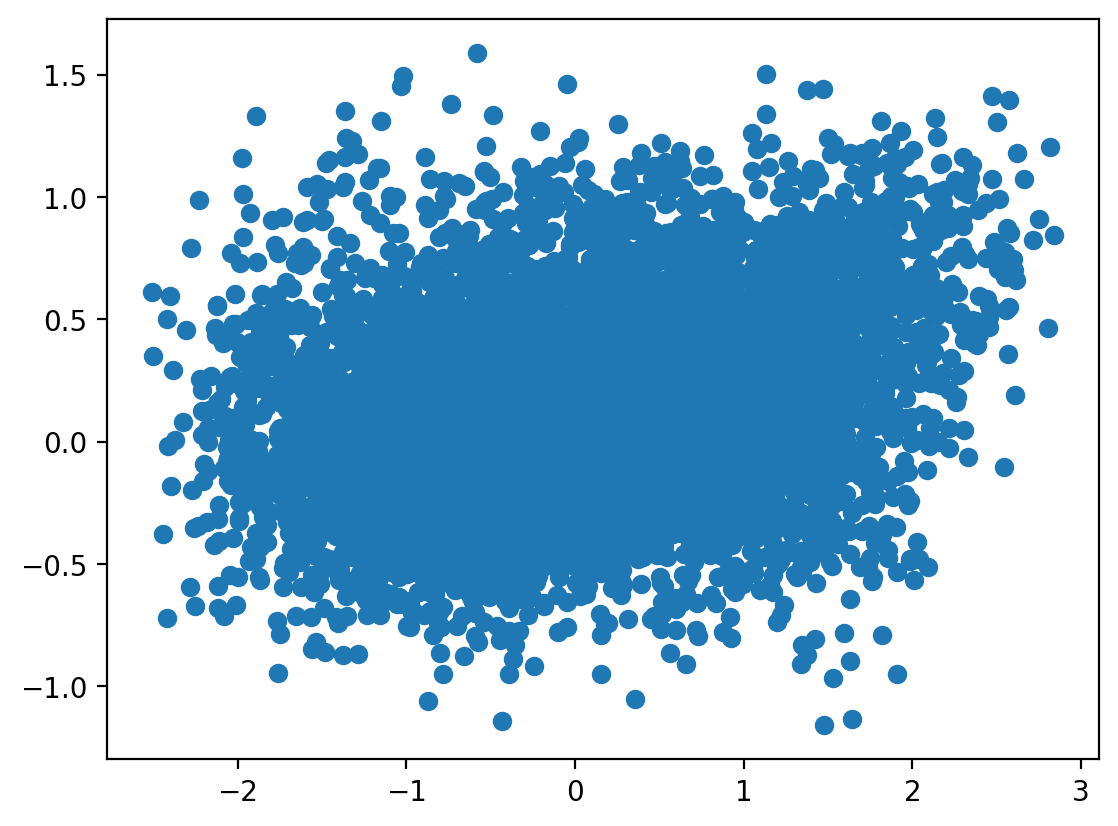

In [19]:
plt.scatter(y[ix_clean], yhat[ix_clean])

## Mahalanobis-based EKF
(Ting 2007)

In [20]:
agent = rfilter.ExtendedThresholdedKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=0.0,
    observation_covariance=1.0 * jnp.eye(1),
    threshold=50.0,
)

In [21]:
bel_init = agent.init_bel(params_init, cov=0.001)

In [22]:
def callback_fn(bel, bel_pred, y, x, applyfn):
    yhat = applyfn(bel_pred.mean, x[None])
    return yhat

In [23]:
callback = partial(callback_fn, applyfn=agent.vobs_fn)
state_final, yhat = agent.scan(bel_init, y, X, callback)
yhat = yhat.squeeze()

In [24]:
errs = (y - yhat)[ix_clean]
jnp.sqrt(jnp.power(errs, 2).mean())

Array(0.8616489, dtype=float32)

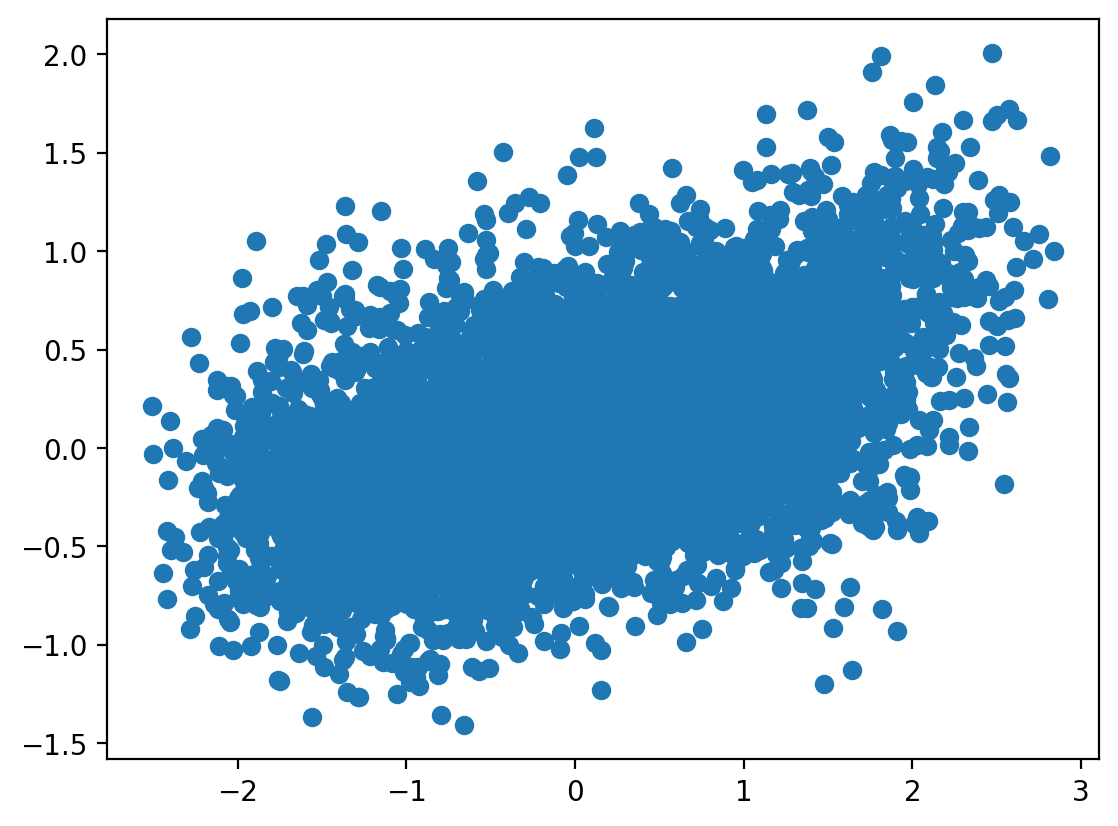

In [25]:
plt.scatter(y[ix_clean], yhat[ix_clean])

## Online SGD

In [26]:
import optax

In [27]:
def lossfn(params, counter, x, y, applyfn):
    yhat = applyfn(params, x)
    return jnp.sum(counter * (y - yhat) ** 2) / counter.sum()

In [28]:
agent = replay_sgd.FifoSGD(
    model.apply,
    lossfn,
    optax.adam(1e-3),
    buffer_size=1,
    dim_features=X.shape[-1],
    dim_output=1,
    n_inner=1
)

In [29]:
callback = partial(callback_fn, applyfn=model.apply)

bel_init = agent.init_bel(params_init)
state_final, yhat = agent.scan(bel_init, y, X, callback)
yhat = yhat.squeeze()

errs = (y - yhat)[ix_clean]
jnp.sqrt(jnp.power(errs, 2).mean())

Array(1.2055849, dtype=float32)

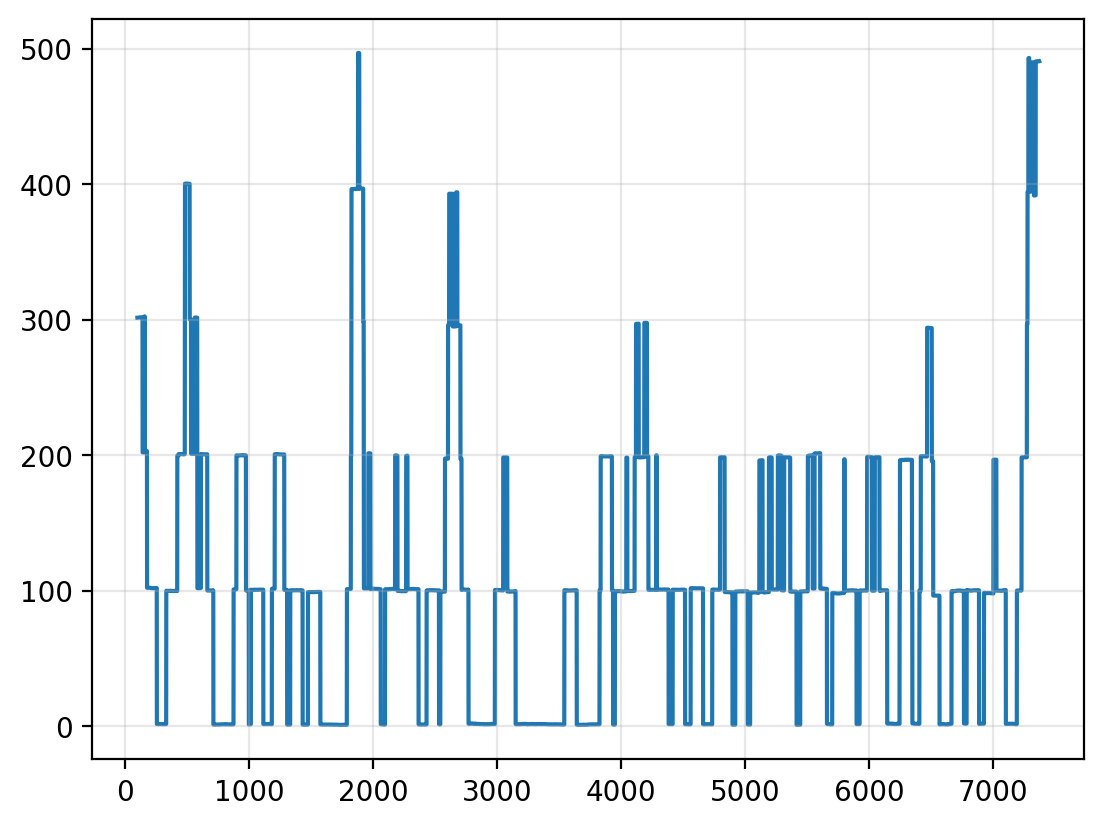

In [31]:
err_where = np.where(~ix_clean)

pd.Series(np.power(y - yhat, 2)).rolling(100).mean().plot(zorder=1)
# plt.grid(alpha=0.3)

# for ix_err in err_where[0]:
#     plt.axvline(x=ix_err, c="black", alpha=0.7)
plt.grid(alpha=0.3)